## Comparing several classification algorigthms using the moons dataset

The idea here is to see graphically how the different classifications algorithms predict classification boundaries. Here we use the mooons dataset, which just generates a random set of data in two half moons, which is a relatively non-trival classification problem, i.e. a logistic regression won't quite work. With just two features we will be able to visually inspect the classification space.

In [1]:
# Import 
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Make toy dataset
X, y = datasets.make_moons(n_samples=100, noise=0.15, random_state=42) #100 samples
Xm, ym = datasets.make_moons(n_samples=1000, noise=0.15, random_state=42) #1,000 samples

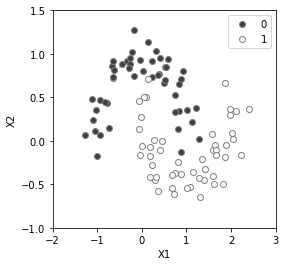

In [2]:
# Quick look at the data
plt.figure(figsize=(4, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "o", label="0", markeredgecolor=[.5,.5,.5],color=[0.25, 0.25, 0.25])
plt.plot(X[y==1, 0], X[y==1, 1], "wo", label="1", markeredgecolor=[.5,.5,.5])
plt.legend()
plt.xlabel('X1')
plt.ylabel('X2')
plt.xlim([-2,3])
plt.ylim([-1,1.5])
plt.savefig('figures/eda006_fig01.png', dpi=150, format='png', bbox_inches='tight')
plt.show()

In [3]:
# Create plotting fxn, This function creates a grid
# to make predictions and then draw a contour. Additionally
# it plots the data on top.
def plot_results(clf, X, y, ax):
    
    # Create grid of predictions
    x0, x1 = np.meshgrid(
            np.linspace(-2, 3, 250).reshape(-1, 1),
            np.linspace(-1, 1.5, 250).reshape(-1, 1),
        )
    X_new = np.c_[x0.ravel(), x1.ravel()]
    
    y_predict = clf.predict(X_new)
    #y_prob = clf.decision_function(X_new)
        
    # Make into grid
    zz = y_predict.reshape(x0.shape)
    #zz_prob = y_prob.reshape(x0.shape)

    # Plot
    cf = ax.contourf(x0, x1, zz, cmap='bone')
    #ax.contour(x0, x1, zz, colors=[(44/255,179/255,238/255)])
    N = len(y)
    if N > 200:
        ax.plot(X[y==1, 0], X[y==1, 1], 'ow',markeredgecolor=[.5,.5,.5], label="1", alpha=.5)
        ax.plot(X[y==0, 0], X[y==0, 1], 'o',markeredgecolor=[.5,.5,.5],color=[0.25, 0.25, 0.25], label="0", alpha=.5)
    else:
        ax.plot(X[y==1, 0], X[y==1, 1], 'ow',markeredgecolor=[.5,.5,.5], label="1")
        ax.plot(X[y==0, 0], X[y==0, 1], 'o',markeredgecolor=[.5,.5,.5],color=[0.25, 0.25, 0.25], label="0")
            
    ax.legend()
    #cf.set_clim(vmin=-10, vmax=10)
    #ax.set_xlabel('X1')
    #ax.set_ylabel('X2')
  

### Logistic Regression

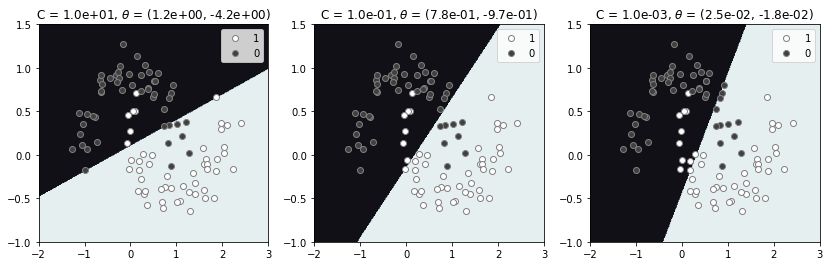

In [4]:
from sklearn.linear_model import LogisticRegression

# Plot model solution and data
fig, axs = plt.subplots(1,3,figsize=(14,4))

vC = [10, 0.1, 0.001]
for i,C in enumerate(vC):
    log_clf = LogisticRegression(C=C)
    log_clf.fit(X,y)
    plot_results(log_clf, X, y,axs[i])
    tstr = r'C = {:2.1e}, $\theta$ = ({:2.1e}, {:2.1e})'.format(C,log_clf.coef_[0][0],log_clf.coef_[0][1])
    axs[i].set_title(tstr)
    
plt.savefig('figures/eda006_fig02.png', dpi=150, format='png', bbox_inches='tight')
plt.show()

The logistic regression looks as we'd expect, with a linear delineation separating the two classes, minimzing the squared error. Increasing regularization (decreasing C) steepens the curve which seems unintuitive, but we should remember that in creasing regularizatin we are only minimizing the model parameters, which see do get smaller. The classification space, in this case happens to rotate into a steeper looking delineation.

### Linear Support Vector Machine

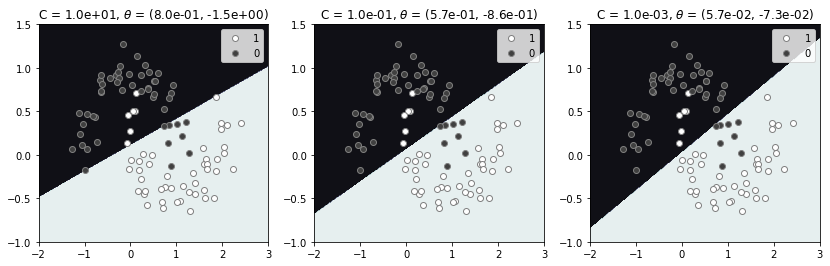

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
scaler = StandardScaler()

# maximum interations, make big, despite scaling sometimes have convergence errors
miter = 50000

# Plot model solution and data
fig, axs = plt.subplots(1, 3, figsize=(14,4), tight_layout=False)

vC = [10, 0.1, 0.001]
for i,C in enumerate(vC):
    # Linear SVM
    svm_clf = LinearSVC(C=C, loss="hinge", max_iter=miter)
    scaled_svm_clf = Pipeline([
        ('scaler', scaler),
        ('linear_scv', svm_clf),
    ])
    scaled_svm_clf.fit(X, y)
    plot_results(scaled_svm_clf, X, y, axs[i])
    tstr = r'C = {:2.1e}, $\theta$ = ({:2.1e}, {:2.1e})'.format(C,svm_clf.coef_[0][0],svm_clf.coef_[0][1])
    axs[i].set_title(tstr)
    
plt.savefig('figures/eda006_fig03.png', dpi=150, format='png', bbox_inches='tight')    
plt.show()

Here, the results look similar to the logistic regression, but regularization does not as strong of an effect graphically. Interestingly, it looks like with minimal regularization the results are the same. A more detailed look at when SVC results converge to the logistic regression can be found [here](https://towardsdatascience.com/support-vector-classifiers-and-logistic-regression-similarity-97ff06aa6ec3#:~:text=Logistic%20Regression%20(LR)%20is%20a,space%20with%20a%20decision%20boundary)

### Non-linear Support Vector Machine

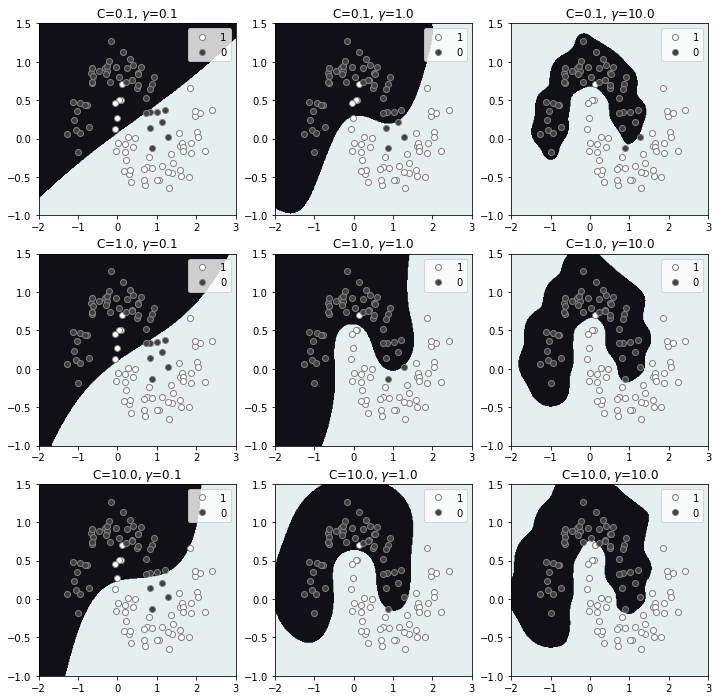

In [6]:
# Note options for kernel, {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
scaler = StandardScaler()

# Plot model solution and data
fig, axs = plt.subplots(3,3,figsize=(12,12))
    
vC = [.1, 1, 10]
vgamma = [0.1, 1, 10]

for i, C in enumerate(vC):
    for j, gamma in enumerate(vgamma):        
        nl_svm_clf = SVC(kernel="rbf", gamma=gamma, C=C)
        scaled_nl_svm_clf = Pipeline([
            ('scaler', scaler),
            ('nonlinear_scv', nl_svm_clf),
        ])        
        scaled_nl_svm_clf.fit(X, y)
        plot_results(scaled_nl_svm_clf, X, y, axs[i,j])
        axs[i,j].set_title(r'C={:.1f}, $\gamma$={:.1f}'.format(C,gamma))

plt.savefig('figures/eda006_fig04.png', dpi=150, format='png', bbox_inches='tight')        
plt.show()

What's really nice about SVMs is that we can relatively easily, and quickly utilize non-linear solutions (through the "kernel trick") and still be guarenteed a convex solution space without local minimums. Here, the inverse of C still controls the regularizatin while an additional parameter $\gamma$, controls the degree of non-linearity. Increasing $\gamma$ allows for more *wiggles* to better fit the data, but this can of course, also lead to overfitting. In the results above C=1.0 and $\gamma=1.0$ appear to be most reasonable solution to the solution space, which, maybe by coincidence, are near default values. 

Note that here we used the radial basis function (rbf), which is just one option for the kernel, and in this case the most reasonable, but it worth exploring the others

### Decision Tree

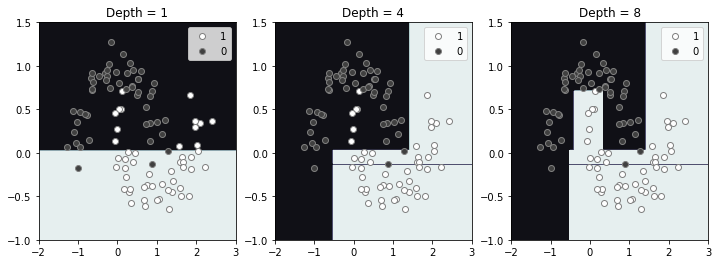

In [7]:
from sklearn.tree import DecisionTreeClassifier

fig, axs = plt.subplots(1,3,figsize=(12,4))

vD = [1, 4, 8]

for i, D in enumerate(vD):
    tree_clf = DecisionTreeClassifier(max_depth=D)
    tree_clf.fit(X,y)
    plot_results(tree_clf, X, y, axs[i])
    axs[i].set_title('Depth = {:d}'.format(D))

plt.savefig('figures/eda006_fig05.png', dpi=150, format='png', bbox_inches='tight')    
plt.show()

Implementing a decision tree here illustrates how with increasing depth we have increasing squared detail. In a way the solution is very linear but in a "boxy" sort of way. This follows from the nature of a decision tree have specific values for a given feature for which a decisions is made

(-1.0, 1.5)

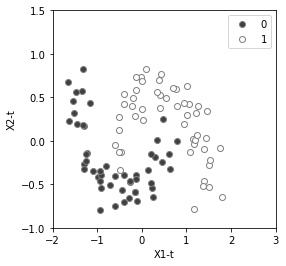

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X)
Xt = pca.transform(X)
pca.explained_variance_
plt.figure(figsize=(4, 4))
plt.plot(Xt[y==0, 0], Xt[y==0, 1], "o", label="0", markeredgecolor=[.5,.5,.5],color=[0.25, 0.25, 0.25])
plt.plot(Xt[y==1, 0], Xt[y==1, 1], "wo", label="1", markeredgecolor=[.5,.5,.5])
plt.legend()
plt.xlabel('X1-t')
plt.ylabel('X2-t')
plt.xlim([-2,3])
plt.ylim([-1,1.5])

### Random Forrest

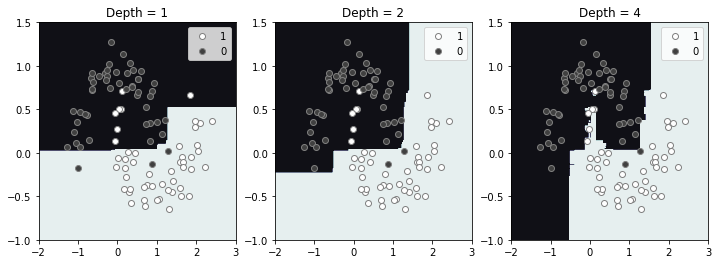

In [8]:
from sklearn.ensemble import RandomForestClassifier

fig, axs = plt.subplots(1,3,figsize=(12,4))

vD = [1, 2, 4]

for i, D in enumerate(vD):
    rf_clf = RandomForestClassifier(n_estimators=100, max_depth=D)
    rf_clf.fit(X,y)
    plot_results(rf_clf, X, y, axs[i])
    axs[i].set_title('Depth = {:d}'.format(D))

plt.savefig('figures/eda006_fig06.png', dpi=150, format='png', bbox_inches='tight')    
plt.show()

### K-nearest Neighbors

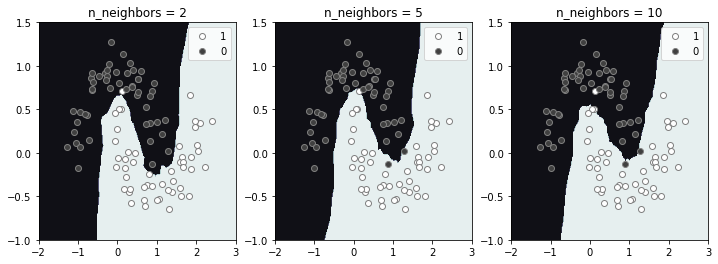

In [9]:
from sklearn.neighbors import KNeighborsClassifier

fig, axs = plt.subplots(1,3,figsize=(12,4))

vD = [2, 5, 10]

for i, D in enumerate(vD):
    knn_clf = KNeighborsClassifier(n_neighbors=D)
    knn_clf.fit(X,y)
    plot_results(knn_clf, X, y, axs[i])
    axs[i].set_title('n_neighbors = {:d}'.format(D))

plt.savefig('figures/eda006_fig07.png', dpi=150, format='png', bbox_inches='tight')    
plt.show()

K-nearest Neighbors makes a plausible decision space with increasing K reducing noise and potential overfitting, but also reducing features that may be desired. 

### Neural Network, MLP Classifier

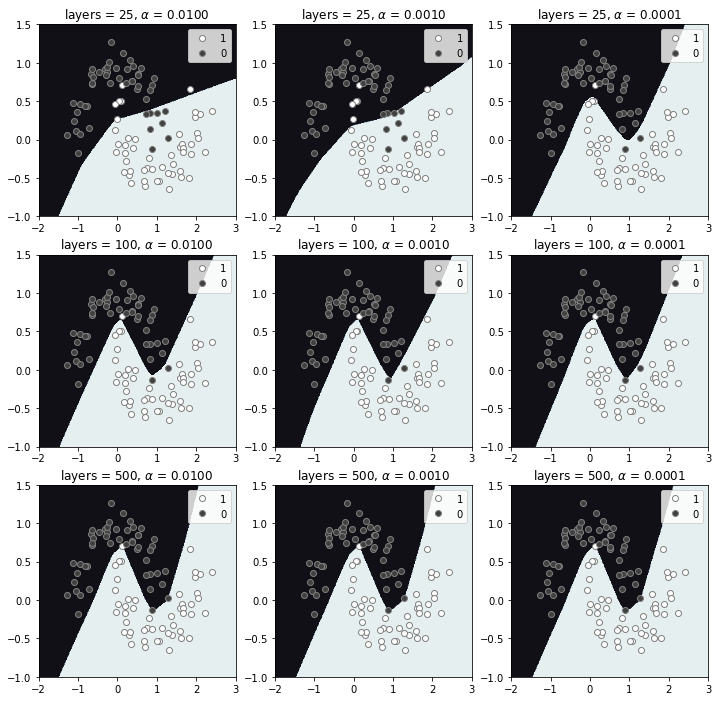

In [10]:
from sklearn.neural_network import MLPClassifier

fig, axs = plt.subplots(3,3,figsize=(12,12))
# axs = axs.ravel() # Make matrix a list

vlayer = [25, 100, 500]
valpha = [0.01, 0.001, 0.0001]

for i, layer in enumerate(vlayer):
    for j, alpha in enumerate(valpha):
        
        mlp_clf = MLPClassifier(max_iter=5000, hidden_layer_sizes=layer, alpha=alpha)
        mlp_clf.fit(X,y)
        plot_results(mlp_clf, X, y, axs[i,j])
        axs[i,j].set_title(r'layers = {:d}, $\alpha$ = {:.4f}'.format(layer,alpha))

plt.savefig('figures/eda006_fig08.png', dpi=150, format='png', bbox_inches='tight')        
plt.show()

Employing a neural network is certainly more computationally costly, but provides a relatively probable solution in this case, drawing straight lines wher it can to encapsulate the decision space. Increasing the number of hidden layers allows for some additional features and tends to include two additonal data as seen in the bottom row, however may likely lead to overfitting. The regularization parameter, $\alpha$, only appears to have an affect with a small number of layers (25), which is relatively unclear. With 100-layers (the default) decreasing the regularization ($\alpha$) appears to smooth sharp transitions (corners).

### Impacts of data density

Here let's briefly examine how increasing data density by a factor of 10 affects solutions to these various models.

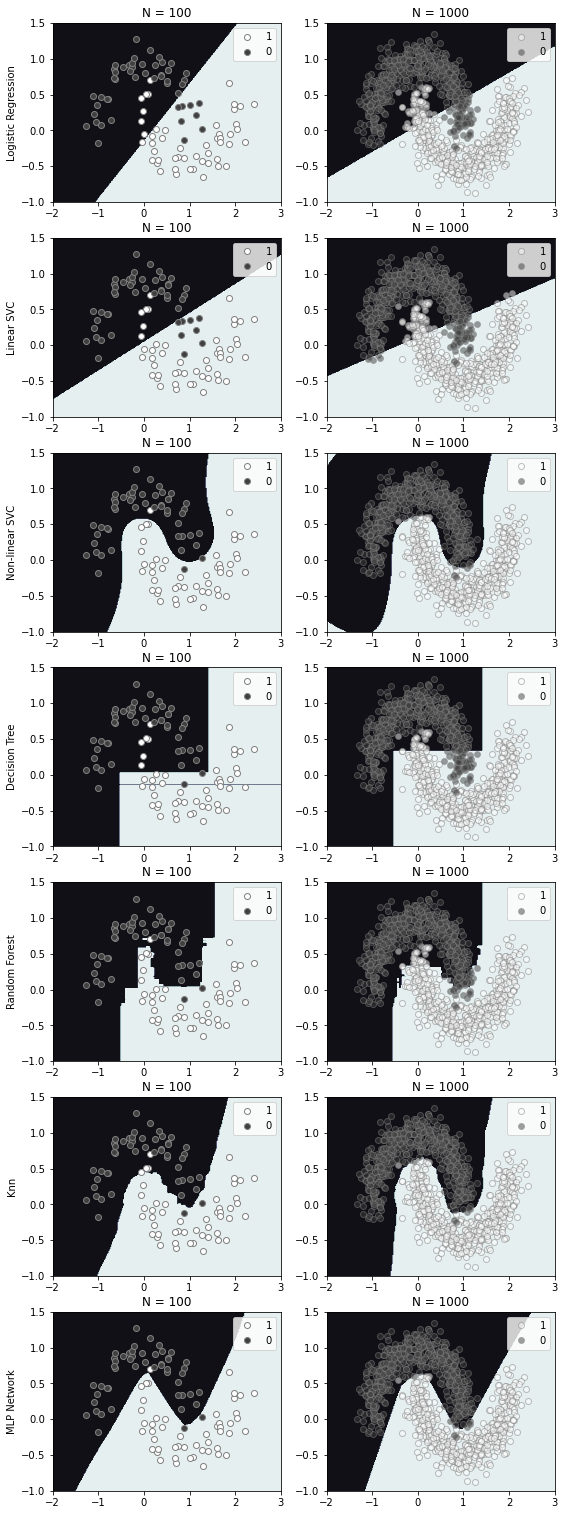

In [13]:
fig, axs = plt.subplots(7,2,figsize=(9,27))

i = 0
log_clf = LogisticRegression(C=0.1)
log_clf.fit(X,y)
plot_results(log_clf,X,y,axs[i,0])
axs[i,0].set_ylabel('Logistic Regression')
axs[i,0].set_title('N = 100')
log_clf.fit(Xm,ym)
plot_results(log_clf, Xm, ym, axs[i,1])
axs[i,1].set_title('N = 1000')

i = 1
lsvc_clf = LinearSVC(C=0.1)
lsvc_clf.fit(X,y)
plot_results(lsvc_clf,X,y,axs[i,0])
axs[i,0].set_ylabel('Linear SVC')
axs[i,0].set_title('N = 100')
lsvc_clf.fit(Xm,ym)
plot_results(lsvc_clf, Xm, ym, axs[i,1])
axs[i,1].set_title('N = 1000')

i = 2
nl_svm_clf = SVC(kernel="rbf", gamma=1, C=1)
scaled_nl_svm_clf = Pipeline([
    ('scaler', scaler),
    ('nonlinear_scv', nl_svm_clf),
])        
scaled_nl_svm_clf.fit(X, y)
plot_results(scaled_nl_svm_clf,X,y,axs[i,0])
axs[i,0].set_ylabel('Non-linear SVC')
axs[i,0].set_title('N = 100')
scaled_nl_svm_clf.fit(Xm,ym)
plot_results(scaled_nl_svm_clf, Xm, ym, axs[i,1])
axs[i,1].set_title('N = 1000')

i = 3
tree_clf = DecisionTreeClassifier(max_depth=4)
tree_clf.fit(X,y)
plot_results(tree_clf,X,y,axs[i,0])
axs[i,0].set_ylabel('Decision Tree')
axs[i,0].set_title('N = 100')
tree_clf.fit(Xm,ym)
plot_results(tree_clf, Xm, ym, axs[i,1])
axs[i,1].set_title('N = 1000')

i = 4
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=4)
rf_clf.fit(X,y)
plot_results(rf_clf,X,y,axs[i,0])
axs[i,0].set_ylabel('Random Forest')
axs[i,0].set_title('N = 100')
rf_clf.fit(Xm,ym)
plot_results(rf_clf, Xm, ym, axs[i,1])
axs[i,1].set_title('N = 1000')

i = 5
knn_clf = KNeighborsClassifier(n_neighbors=15)
knn_clf.fit(X,y)
plot_results(knn_clf,X,y,axs[i,0])
axs[i,0].set_ylabel('Knn')
axs[i,0].set_title('N = 100')
knn_clf.fit(Xm,ym)
plot_results(knn_clf, Xm, ym, axs[i,1])
axs[i,1].set_title('N = 1000')


i = 6
mlp_clf = MLPClassifier(max_iter=5000, hidden_layer_sizes=100, alpha=0.01)
mlp_clf.fit(X,y)
plot_results(mlp_clf,X,y,axs[i,0])
axs[i,0].set_ylabel('MLP Network')
axs[i,0].set_title('N = 100')
mlp_clf.fit(Xm,ym)
plot_results(mlp_clf, Xm, ym, axs[i,1])
axs[i,1].set_title('N = 1000')

plt.savefig('figures/eda006_fig09.png', dpi=150, format='png', bbox_inches='tight')
plt.show()

In general adding data tends to improve the decision space of the model. Interestinly, for this particular case it appears that the non-linear SVC solution may be best (though a train-test set approach is needed to confirm this). It may be because the dataset is inherently curvy across parameter space, something non-linear SVC does quite well compared to linear approaches, decision trees, and neural networks. The nearest neighbors approach (Knn) looks similar for larger n_neighbors (15 here), but has some noisy features at lower values such as 5. As this is simply a toy model, I wouldn't take these results very seriously, however, the figures here give me some intuition for how these model solutions look and vary.